In [7]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import networkx as nx
import seaborn as sns
import pandas as pd

from nibabel.processing import resample_from_to
from scipy.stats import ttest_ind, ranksums

In [8]:
def build_roi_to_network_map(cc200_file, yeo7_file):
    """
    For each ROI in the Craddock 200 atlas (cc200_file),
    find which Yeo7 network (1..7) it overlaps the most.
    Returns a dict: roi_to_net[roi_id] = net_id (1..7).
    """

    cc200_img = nib.load(cc200_file)
    cc200_data = cc200_img.get_fdata()

    yeo_img = nib.load(yeo7_file)
    yeo_data = yeo_img.get_fdata()

    # Resample Yeo7 if needed
    if cc200_data.shape != yeo_data.shape:
        print("Resampling Yeo7 to CC200 resolution...")
        yeo_img = resample_from_to(yeo_img, cc200_img, order=0)
        yeo_data = yeo_img.get_fdata()

    roi_ids = np.unique(cc200_data[cc200_data>0])  # e.g. 1..200
    yeo_ids = np.unique(yeo_data[yeo_data>0])      # e.g. 1..7

    print(f"Found {len(roi_ids)} CC200 ROIs, {len(yeo_ids)} Yeo7 networks.")

    roi_to_net = {}
    for roi in roi_ids:
        mask = (cc200_data == roi)
        overlap_counts = {}
        for net in yeo_ids:
            overlap_counts[net] = np.sum(yeo_data[mask] == net)
        # find net with maximum overlap
        best_net = max(overlap_counts, key=overlap_counts.get)
        roi_to_net[int(roi)] = int(best_net)

    return roi_to_net

In [9]:
# (A) Provide atlas paths
cc200_file = r"D:\Project_001\NETWORK_FINAL\Atlas\CC200.nii"  # Craddock 200 atlas
yeo7_file  = r"D:\Project_001\NETWORK_FINAL\Atlas\Yeo7_1mm_reoriented.nii.gz"  # Yeo 7 network parcellation
roi_to_net = build_roi_to_network_map(cc200_file, yeo7_file)

Resampling Yeo7 to CC200 resolution...
Found 200 CC200 ROIs, 7 Yeo7 networks.


ASD energies (7-node): n=50
[ 0.12876088  0.10106673  0.12727385  0.01856538  0.11970286  0.20629555
  0.09694514  0.17446912  0.07497002  0.12587417  0.11338839  0.1108344
  0.11173316  0.06463605  0.05592545  0.14725244  0.11261232  0.10489171
  0.22505678  0.14147939  0.07098083  0.25832217  0.1090665   0.07876141
 -0.07473177  0.05503461 -0.01540164  0.03946758  0.10615355  0.04549826
  0.04130884  0.16809023  0.14544802  0.1597527   0.02775322  0.12111952
  0.1523284   0.09744009  0.03969225  0.13476771  0.03014351  0.0104805
  0.12743689  0.06581046  0.19192094  0.00060743  0.15038264  0.10239283
  0.30738644  0.14193432]
Control energies (7-node): n=50
[ 0.11731468  0.10270828  0.20807831  0.13503065  0.19847837  0.18557175
  0.1212947   0.09797158  0.16840351  0.06947374  0.17689404  0.06327535
  0.10365139  0.06599155  0.02604569  0.13259909  0.1027669   0.18273215
  0.2018363   0.16650737 -0.02360468  0.24255425  0.15860496  0.22678199
  0.1243597   0.15525025  0.19442201  0.

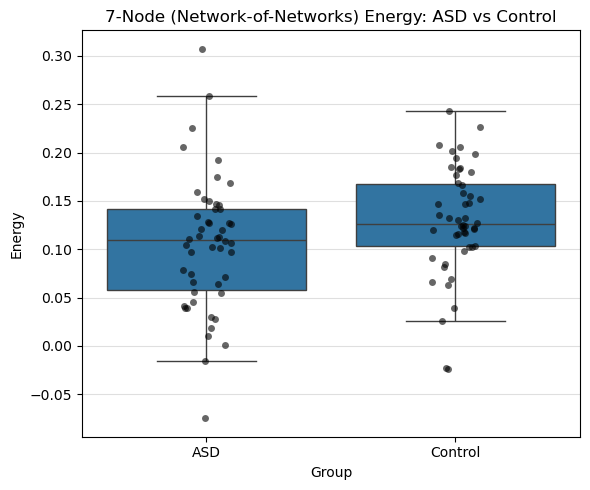

In [5]:
###############################################################################
# 1) LOAD roi_to_net DICTIONARY
###############################################################################
def load_roi_to_net_dict(dict_path="roi_to_net.npy"):
    """
    Load a dictionary mapping each ROI (1..200) to a Yeo network ID (1..7).
    E.g. roi_to_net[1] = 2, etc.
    Must be consistent with your .graphml node IDs.
    """
    # Example: stored as a NumPy .npy with allow_pickle
    data = np.load(dict_path, allow_pickle=True).item()
    # data should be a dict: {1: netID, 2: netID, ..., 200: netID}
    return data

###############################################################################
# 2) BUILD 7-NODE ADJACENCY (AGGREGATE FROM 200-ROI GRAPH)
###############################################################################
def build_7node_adjacency(G_200, roi_to_net, net_ids):
    """
    Given a 200-ROI graph (G_200) and a dictionary roi_to_net,
    create a new 7-node adjacency, where each node k in net_ids has:
      - 'fALFF' = average fALFF of all ROIs in that network
    and edge weight(k,m) = average correlation among all ROI pairs bridging k & m.

    Return (G_7, success_flag).
    G_7 is a 7-node Graph, success_flag = False if something went wrong.
    """
    # 1) Group ROI nodes by network
    rois_in_net = {net: [] for net in net_ids}
    falff_sum_in_net = {net: 0.0 for net in net_ids}
    count_in_net = {net: 0 for net in net_ids}

    # Collect ROI-level data
    for node_str, data in G_200.nodes(data=True):
        try:
            node_id = int(node_str)
        except ValueError:
            continue  # skip if cannot parse
        net = roi_to_net.get(node_id, None)
        if net not in net_ids:
            # This ROI is not mapped or out of range
            continue
        falff_val = data.get('fALFF', None)
        if falff_val is None or np.isnan(falff_val):
            continue
        rois_in_net[net].append(node_id)
        falff_sum_in_net[net] += falff_val
        count_in_net[net] += 1

    # 2) Compute each network's node fALFF (mean)
    node_falff_7 = {}
    for net in net_ids:
        if count_in_net[net] > 0:
            node_falff_7[net] = falff_sum_in_net[net] / count_in_net[net]
        else:
            node_falff_7[net] = np.nan  # or 0

    # 3) Build 7x7 edge weights
    # We'll sum all corr for ROI pairs bridging (k, m) and then divide by # of pairs
    pair_sum = {}
    pair_count = {}
    for k in net_ids:
        for m in net_ids:
            if k <= m:
                # we'll handle only upper triangle, then mirror
                pair_sum[(k,m)] = 0.0
                pair_count[(k,m)] = 0

    # Loop over edges in G_200
    for u_str, v_str, edata in G_200.edges(data=True):
        try:
            u_id = int(u_str)
            v_id = int(v_str)
        except ValueError:
            continue
        net_u = roi_to_net.get(u_id, None)
        net_v = roi_to_net.get(v_id, None)
        if net_u not in net_ids or net_v not in net_ids:
            continue
        w = edata.get('weight', None)
        if w is None or np.isnan(w):
            continue
        # order k<m
        k, m = sorted([net_u, net_v])
        if k == m:
            # intra-network edge
            pair_sum[(k,m)] += w
            pair_count[(k,m)] += 1
        else:
            # inter-network edge
            pair_sum[(k,m)] += w
            pair_count[(k,m)] += 1

    # Build a new 7-node Graph
    G_7 = nx.Graph()
    for net in net_ids:
        G_7.add_node(net, fALFF=node_falff_7[net])

    for k in net_ids:
        for m in net_ids:
            if k < m:
                s = pair_sum[(k,m)]
                c = pair_count[(k,m)]
                w_7 = s / c if c>0 else 0.0
                G_7.add_edge(k, m, weight=w_7)
                G_7.add_edge(m, k, weight=w_7)
        # diagonal if you want to store it, typically we skip

    # If any node_falff_7 is nan for all or no valid edges, we might fail
    success_flag = True
    return G_7, success_flag

###############################################################################
# 3) COMPUTE COEVOLUTIONARY ENERGY ON A 7-NODE GRAPH
###############################################################################
def compute_energy_7node(G_7, net_ids):
    """
    E = - sum_{k<m} [fALFF[k] * weight[k,m] * fALFF[m]]
    skip if any is NaN
    """
    energy_sum = 0.0
    for i in range(len(net_ids)):
        for j in range(i+1, len(net_ids)):
            k = net_ids[i]
            m = net_ids[j]
            falff_k = G_7.nodes[k].get('fALFF', None)
            falff_m = G_7.nodes[m].get('fALFF', None)
            w = G_7[k][m].get('weight', None) if G_7.has_edge(k,m) else None
            if (falff_k is None or falff_m is None or w is None):
                continue
            if any(np.isnan([falff_k, falff_m, w])):
                continue
            energy_sum += (falff_k * w * falff_m)
    return -energy_sum

###############################################################################
# 4) MAIN SCRIPT
###############################################################################
def main():
    # 1) Load roi_to_net dictionary
    #roi_to_net_path = "roi_to_net.npy"  # adjust as needed
    #roi_to_net = np.load(roi_to_net_path, allow_pickle=True).item()
    # e.g. roi_to_net[1] = 3, roi_to_net[2] = 1, etc.

    # 2) Define 7 Yeo networks
    net_ids = [1,2,3,4,5,6,7]

    # 3) Directories
    asd_dir = r"D:\Project_001\NETWORK_FINAL\ASDNetworks"
    ctrl_dir = r"D:\Project_001\NETWORK_FINAL\ControlNetworks"
    out_dir  = r"D:\Project_001\NETWORK_FINAL\NetworksXNetworks"
    os.makedirs(out_dir, exist_ok=True)

    asd_files  = glob.glob(os.path.join(asd_dir, "*.graphml"))
    ctrl_files = glob.glob(os.path.join(ctrl_dir, "*.graphml"))

    # We'll store energies in asd_energies_7 and ctrl_energies_7
    asd_energies_7 = []
    ctrl_energies_7 = []

    # Helper function to process a single .graphml => 7-node graph => energy
    def process_subject_7node(graph_file):
        G_200 = nx.read_graphml(graph_file)
        # Build 7-node adjacency
        G_7, success = build_7node_adjacency(G_200, roi_to_net, net_ids)
        if not success:
            return np.nan, None
        # Optionally save G_7
        # subject_id from filename
        base = os.path.basename(graph_file)
        subject_id = os.path.splitext(base)[0]
        out_g7_file = os.path.join(out_dir, f"{subject_id}_7net.graphml")
        nx.write_graphml(G_7, out_g7_file)
        # compute energy
        E_7 = compute_energy_7node(G_7, net_ids)
        return E_7, G_7

    # (A) Process ASD
    for gf in asd_files:
        E_7, G_7 = process_subject_7node(gf)
        if not np.isnan(E_7):
            asd_energies_7.append(E_7)

    # (B) Process Control
    for gf in ctrl_files:
        E_7, G_7 = process_subject_7node(gf)
        if not np.isnan(E_7):
            ctrl_energies_7.append(E_7)

    # 4) Convert to arrays
    asd_energies_7 = np.array(asd_energies_7, dtype=float)
    ctrl_energies_7 = np.array(ctrl_energies_7, dtype=float)

    print(f"ASD energies (7-node): n={len(asd_energies_7)}")
    print(asd_energies_7)
    print(f"Control energies (7-node): n={len(ctrl_energies_7)}")
    print(ctrl_energies_7)

    # 5) Group-level comparison
    if len(asd_energies_7)<2 or len(ctrl_energies_7)<2:
        print("Not enough valid data to do stats.")
        return

    # T-test
    t_res = ttest_ind(asd_energies_7, ctrl_energies_7, equal_var=False)
    # Wilcoxon rank-sum
    r_res = ranksums(asd_energies_7, ctrl_energies_7)

    print("\n=== 7-Node Energy: ASD vs Control ===")
    print(f"T-test: t={t_res.statistic:.3f}, p={t_res.pvalue:.4g}")
    print(f"Rank-sum: stat={r_res.statistic:.3f}, p={r_res.pvalue:.4g}")

    # 6) Plot
    df = pd.DataFrame({
        "Group": ["ASD"]*len(asd_energies_7) + ["Control"]*len(ctrl_energies_7),
        "Energy": np.concatenate([asd_energies_7, ctrl_energies_7])
    })

    plt.figure(figsize=(6,5))
    sns.boxplot(x="Group", y="Energy", data=df, showfliers=False)
    sns.stripplot(x="Group", y="Energy", data=df, color="black", alpha=0.6, jitter=True)
    plt.title("7-Node (Network-of-Networks) Energy: ASD vs Control")
    plt.grid(True, axis='y', alpha=0.4)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


ASD energies (7-node): n=93
[ 0.08547228  0.09325724  0.03013638  0.20215778  0.03199297  0.11539789
  0.08942735  0.10074762  0.15031067  0.08369907  0.14934551  0.15003706
  0.1371221   0.13910503  0.06757555  0.01078739  0.19961262  0.18754574
  0.20385744  0.08357875  0.0879007   0.15627485  0.15817687  0.02526949
  0.2044224   0.2648736   0.10854122  0.22757545  0.24349274  0.18040855
  0.14576828  0.13018417  0.06354913  0.13157957  0.14273688  0.11453098
  0.16777056  0.1495764   0.12710322  0.1696094   0.1442243   0.13319517
  0.11465252  0.15697973  0.02217443  0.18770735 -0.00376174  0.0267483
  0.1186301   0.12011528  0.12876088  0.10106673  0.01856538  0.11970286
  0.20629555  0.09694514  0.17446912  0.07497002  0.12587417  0.11338839
  0.1108344   0.11173316  0.05592545  0.14725244  0.11261232  0.10489171
  0.22505678  0.14147939  0.25832217  0.1090665   0.07876141  0.05503461
 -0.01540164  0.10615355  0.04549826  0.04130884  0.16809023  0.14544802
  0.1597527   0.02775322

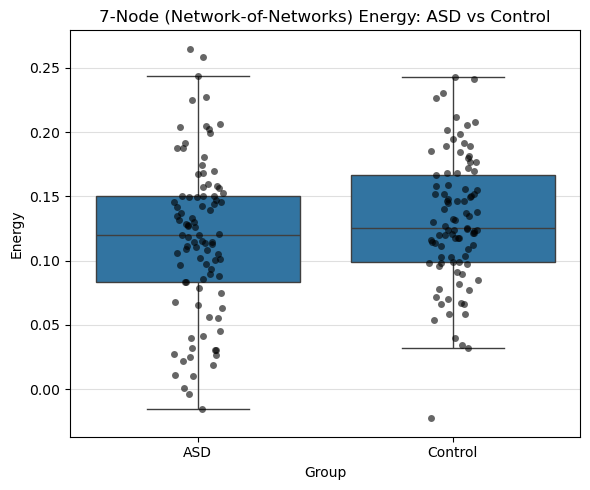

In [6]:
import os
import glob
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import ttest_ind, ranksums

###############################################################################
# 1) BUILD 7-NODE ADJACENCY (AGGREGATE FROM 200-ROI GRAPH)
###############################################################################
def build_7node_adjacency(G_200, roi_to_net, net_ids):
    """
    Summarize a 200-ROI graph into a 7-node graph (one node per Yeo network).
    Node 'fALFF' = average of ROIs' fALFF in that network.
    Edge 'weight' = average correlation among all ROI pairs bridging those networks.
    Returns (G_7, success_flag).
    """
    rois_in_net = {net: [] for net in net_ids}
    falff_sum_in_net = {net: 0.0 for net in net_ids}
    count_in_net = {net: 0 for net in net_ids}

    # Collect ROI-level data
    for node_str, data in G_200.nodes(data=True):
        try:
            node_id = int(node_str)
        except ValueError:
            continue  # skip if cannot parse
        net = roi_to_net.get(node_id, None)
        if net not in net_ids:
            continue
        falff_val = data.get('fALFF', None)
        if falff_val is None or np.isnan(falff_val):
            continue
        rois_in_net[net].append(node_id)
        falff_sum_in_net[net] += falff_val
        count_in_net[net] += 1

    # Compute each network's node fALFF (mean)
    node_falff_7 = {}
    for net in net_ids:
        if count_in_net[net] > 0:
            node_falff_7[net] = falff_sum_in_net[net] / count_in_net[net]
        else:
            node_falff_7[net] = np.nan

    # Summation structures for edges
    pair_sum = {}
    pair_count = {}
    for k in net_ids:
        for m in net_ids:
            if k <= m:
                pair_sum[(k,m)] = 0.0
                pair_count[(k,m)] = 0

    # Loop over edges in G_200
    for u_str, v_str, edata in G_200.edges(data=True):
        try:
            u_id = int(u_str)
            v_id = int(v_str)
        except ValueError:
            continue
        net_u = roi_to_net.get(u_id, None)
        net_v = roi_to_net.get(v_id, None)
        if net_u not in net_ids or net_v not in net_ids:
            continue
        w = edata.get('weight', None)
        if w is None or np.isnan(w):
            continue
        k, m = sorted([net_u, net_v])
        pair_sum[(k,m)] += w
        pair_count[(k,m)] += 1

    # Build a new 7-node Graph
    G_7 = nx.Graph()
    for net in net_ids:
        G_7.add_node(net, fALFF=node_falff_7[net])

    for k in net_ids:
        for m in net_ids:
            if k < m:
                s = pair_sum[(k,m)]
                c = pair_count[(k,m)]
                w_7 = s / c if c>0 else 0.0
                G_7.add_edge(k, m, weight=w_7)
                G_7.add_edge(m, k, weight=w_7)

    success_flag = True
    return G_7, success_flag

###############################################################################
# 2) COMPUTE COEVOLUTIONARY ENERGY AT 7-NODE SCALE
###############################################################################
def compute_energy_7node(G_7, net_ids):
    """
    E = - sum_{k<m} [fALFF[k] * weight[k,m] * fALFF[m]], skipping NaNs.
    """
    energy_sum = 0.0
    for i in range(len(net_ids)):
        for j in range(i+1, len(net_ids)):
            k = net_ids[i]
            m = net_ids[j]
            falff_k = G_7.nodes[k].get('fALFF', None)
            falff_m = G_7.nodes[m].get('fALFF', None)
            if G_7.has_edge(k, m):
                w = G_7[k][m].get('weight', None)
            else:
                w = None
            if (falff_k is None or falff_m is None or w is None):
                continue
            if any(np.isnan([falff_k, falff_m, w])):
                continue
            energy_sum += (falff_k * w * falff_m)
    return -energy_sum

###############################################################################
# 3) MAIN
###############################################################################
def main():
    # Load your roi_to_net dictionary
    #roi_to_net_path = "roi_to_net.npy"  # adjust as needed
    #roi_to_net = np.load(roi_to_net_path, allow_pickle=True).item()

    net_ids = [1,2,3,4,5,6,7]

    # Directories
    asd_dir   = r"D:\Project_001\NETWORK_FINAL\ASDNetworks\Full"
    ctrl_dir  = r"D:\Project_001\NETWORK_FINAL\ControlNetworks\Full"

    # Output directories for 7-node networks
    out_dir   = r"D:\Project_001\NETWORK_FINAL\NetworksXNetworks\Outlier_Controlled"
    out_dir_asd  = os.path.join(out_dir, "ASD")
    out_dir_ctrl = os.path.join(out_dir, "Control")
    os.makedirs(out_dir_asd, exist_ok=True)
    os.makedirs(out_dir_ctrl, exist_ok=True)

    asd_files  = glob.glob(os.path.join(asd_dir, "*.graphml"))
    ctrl_files = glob.glob(os.path.join(ctrl_dir, "*.graphml"))

    asd_energies_7 = []
    ctrl_energies_7 = []

    def process_subject_7node(graph_file, out_dir):
        G_200 = nx.read_graphml(graph_file)
        G_7, success = build_7node_adjacency(G_200, roi_to_net, net_ids)
        if not success:
            return np.nan
        # Save 7-node GraphML
        base = os.path.basename(graph_file)
        subject_id = os.path.splitext(base)[0]
        out_g7_file = os.path.join(out_dir, f"{subject_id}_7net.graphml")
        nx.write_graphml(G_7, out_g7_file)
        # Compute energy
        E_7 = compute_energy_7node(G_7, net_ids)
        return E_7

    # Process ASD
    for gf in asd_files:
        E_7 = process_subject_7node(gf, out_dir_asd)
        if not np.isnan(E_7):
            asd_energies_7.append(E_7)

    # Process Control
    for gf in ctrl_files:
        E_7 = process_subject_7node(gf, out_dir_ctrl)
        if not np.isnan(E_7):
            ctrl_energies_7.append(E_7)

    asd_energies_7 = np.array(asd_energies_7, dtype=float)
    ctrl_energies_7 = np.array(ctrl_energies_7, dtype=float)

    print(f"ASD energies (7-node): n={len(asd_energies_7)}")
    print(asd_energies_7)
    print(f"Control energies (7-node): n={len(ctrl_energies_7)}")
    print(ctrl_energies_7)

    # Stats
    if len(asd_energies_7)<2 or len(ctrl_energies_7)<2:
        print("Not enough valid data to do stats.")
        return

    t_res = ttest_ind(asd_energies_7, ctrl_energies_7, equal_var=False)
    r_res = ranksums(asd_energies_7, ctrl_energies_7)
    print("\n=== 7-Node Energy: ASD vs Control ===")
    print(f"T-test: t={t_res.statistic:.3f}, p={t_res.pvalue:.4g}")
    print(f"Rank-sum: stat={r_res.statistic:.3f}, p={r_res.pvalue:.4g}")

    # Plot
    df = pd.DataFrame({
        "Group": ["ASD"]*len(asd_energies_7) + ["Control"]*len(ctrl_energies_7),
        "Energy": np.concatenate([asd_energies_7, ctrl_energies_7])
    })

    plt.figure(figsize=(6,5))
    sns.boxplot(x="Group", y="Energy", data=df, showfliers=False)
    sns.stripplot(x="Group", y="Energy", data=df, color="black", alpha=0.6, jitter=True)
    plt.title("7-Node (Network-of-Networks) Energy: ASD vs Control")
    plt.grid(True, axis='y', alpha=0.4)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Found 86 ASD 7-node energies.
Found 86 Control 7-node energies.
Found 5 outlier subjects (any group).
Outlier subject IDs: {'0050521', '0050482', '0050131', '0051237', '0051318'}
ASD final n=81, Control final n=86 after outlier removal.

=== 7-Node Energy (Outliers Excluded) ===
ASD n=81, Control n=86
T-test: t=-1.722, p=0.08708
Rank-sum: stat=-1.479, p=0.139


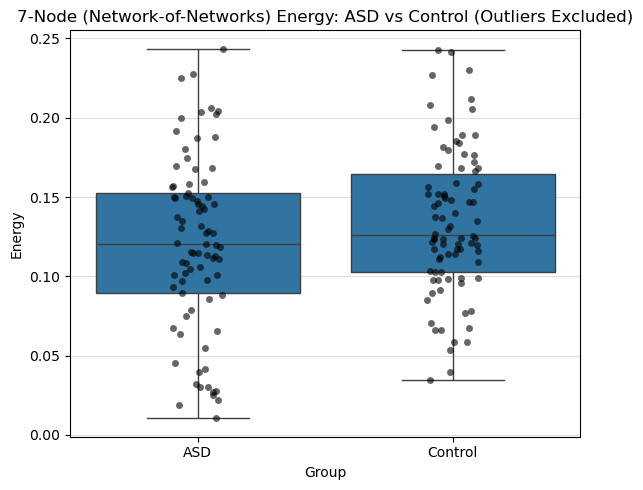

In [10]:
import os
import glob
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nibabel.processing import resample_from_to
from scipy.stats import ttest_ind, ranksums

###############################################################################
# 1) BUILD 7-NODE ADJACENCY (AGGREGATE FROM 200-ROI GRAPH)
###############################################################################
def build_7node_adjacency(G_200, roi_to_net, net_ids):
    """
    Summarize a 200-ROI graph into a 7-node graph (one node per Yeo network).
    Node 'fALFF' = average of ROIs' fALFF in that network.
    Edge 'weight' = average correlation among all ROI pairs bridging those networks.
    Returns (G_7, success_flag).
    """
    rois_in_net = {net: [] for net in net_ids}
    falff_sum_in_net = {net: 0.0 for net in net_ids}
    count_in_net = {net: 0 for net in net_ids}

    # Collect ROI-level data
    for node_str, data in G_200.nodes(data=True):
        try:
            node_id = int(node_str)
        except ValueError:
            continue  # skip if cannot parse
        net = roi_to_net.get(node_id, None)
        if net not in net_ids:
            continue
        falff_val = data.get('fALFF', None)
        if falff_val is None or np.isnan(falff_val):
            continue
        rois_in_net[net].append(node_id)
        falff_sum_in_net[net] += falff_val
        count_in_net[net] += 1

    # Compute each network's node fALFF (mean)
    node_falff_7 = {}
    for net in net_ids:
        if count_in_net[net] > 0:
            node_falff_7[net] = falff_sum_in_net[net] / count_in_net[net]
        else:
            node_falff_7[net] = np.nan

    # Summation structures for edges
    pair_sum = {}
    pair_count = {}
    for k in net_ids:
        for m in net_ids:
            if k <= m:
                pair_sum[(k,m)] = 0.0
                pair_count[(k,m)] = 0

    # Loop over edges in G_200
    for u_str, v_str, edata in G_200.edges(data=True):
        try:
            u_id = int(u_str)
            v_id = int(v_str)
        except ValueError:
            continue
        net_u = roi_to_net.get(u_id, None)
        net_v = roi_to_net.get(v_id, None)
        if net_u not in net_ids or net_v not in net_ids:
            continue
        w = edata.get('weight', None)
        if w is None or np.isnan(w):
            continue
        k, m = sorted([net_u, net_v])
        pair_sum[(k,m)] += w
        pair_count[(k,m)] += 1

    # Build a new 7-node Graph
    G_7 = nx.Graph()
    for net in net_ids:
        G_7.add_node(net, fALFF=node_falff_7[net])

    for k in net_ids:
        for m in net_ids:
            if k < m:
                s = pair_sum[(k,m)]
                c = pair_count[(k,m)]
                w_7 = s / c if c>0 else 0.0
                G_7.add_edge(k, m, weight=w_7)
                G_7.add_edge(m, k, weight=w_7)

    success_flag = True
    return G_7, success_flag

###############################################################################
# 2) COMPUTE COEVOLUTIONARY ENERGY AT 7-NODE SCALE
###############################################################################
def compute_energy_7node(G_7, net_ids):
    """
    E = - sum_{k<m} [fALFF[k] * weight[k,m] * fALFF[m]], skipping NaNs.
    """
    energy_sum = 0.0
    for i in range(len(net_ids)):
        for j in range(i+1, len(net_ids)):
            k = net_ids[i]
            m = net_ids[j]
            falff_k = G_7.nodes[k].get('fALFF', None)
            falff_m = G_7.nodes[m].get('fALFF', None)
            if G_7.has_edge(k, m):
                w = G_7[k][m].get('weight', None)
            else:
                w = None
            if (falff_k is None or falff_m is None or w is None):
                continue
            if any(np.isnan([falff_k, falff_m, w])):
                continue
            energy_sum += (falff_k * w * falff_m)
    return -energy_sum

###############################################################################
# 3) IQR-BASED OUTLIER DETECTION
###############################################################################
def identify_outliers_iqr(values, iqr_factor=1.5):
    """
    Returns a boolean mask of outliers:
      below Q1 - iqr_factor*IQR or above Q3 + iqr_factor*IQR.
    """
    if len(values) < 2:
        return np.zeros(len(values), dtype=bool)

    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_factor * iqr
    upper_bound = q3 + iqr_factor * iqr

    return (values < lower_bound) | (values > upper_bound)

###############################################################################
# 4) MAIN
###############################################################################
def main():
    # We'll assume you have roi_to_net dict loaded or define it
    # e.g., from a file or a function. For example:
    # roi_to_net = np.load("roi_to_net.npy", allow_pickle=True).item()

    #roi_to_net = {}  # TODO: load or define your dictionary
    net_ids = [1,2,3,4,5,6,7]

    # Directories
    asd_dir   = r"D:\Project_001\NETWORK_FINAL\ASDNetworks\Partially_Full"
    ctrl_dir  = r"D:\Project_001\NETWORK_FINAL\ControlNetworks\Partially_Full"

    out_dir   = r"D:\Project_001\NETWORK_FINAL\NetworksXNetworks\Outlier_Controlled"
    out_dir_asd  = os.path.join(out_dir, "ASD")
    out_dir_ctrl = os.path.join(out_dir, "Control")
    os.makedirs(out_dir_asd, exist_ok=True)
    os.makedirs(out_dir_ctrl, exist_ok=True)

    asd_files  = glob.glob(os.path.join(asd_dir, "*.graphml"))
    ctrl_files = glob.glob(os.path.join(ctrl_dir, "*.graphml"))

    # We'll store (subject_id, energy) for each group
    asd_energy_list = []
    ctrl_energy_list = []

    def parse_subject_id(fname):
        base = os.path.basename(fname)
        no_ext = os.path.splitext(base)[0]
        # e.g. "Pitt_0050007_network"
        parts = no_ext.split('_')
        if len(parts) >= 2:
            return parts[1]
        else:
            return no_ext

    def process_subject_7node(graph_file, out_dir):
        """
        Build 7-node adjacency => compute E_7 => return (subject_id, E_7).
        If E_7 is NaN, skip.
        """
        subject_id = parse_subject_id(graph_file)
        G_200 = nx.read_graphml(graph_file)
        G_7, success = build_7node_adjacency(G_200, roi_to_net, net_ids)
        if not success:
            return None
        # Save 7-node GraphML
        base = os.path.basename(graph_file)
        no_ext = os.path.splitext(base)[0]
        out_g7_file = os.path.join(out_dir, f"{no_ext}_7net.graphml")
        nx.write_graphml(G_7, out_g7_file)

        E_7 = compute_energy_7node(G_7, net_ids)
        if np.isnan(E_7):
            return None
        return (subject_id, E_7)

    # (A) Process ASD
    for gf in asd_files:
        res = process_subject_7node(gf, out_dir_asd)
        if res is not None:
            asd_energy_list.append(res)  # (subject_id, E_7)

    # (B) Process Control
    for gf in ctrl_files:
        res = process_subject_7node(gf, out_dir_ctrl)
        if res is not None:
            ctrl_energy_list.append(res)  # (subject_id, E_7)

    print(f"Found {len(asd_energy_list)} ASD 7-node energies.")
    print(f"Found {len(ctrl_energy_list)} Control 7-node energies.")

    # Convert to arrays for outlier detection
    # We'll combine ASD + Control to detect outliers across both groups
    combined_data = asd_energy_list + ctrl_energy_list
    if len(combined_data) < 2:
        print("Not enough total data to proceed.")
        return

    energies = np.array([item[1] for item in combined_data], dtype=float)
    outlier_mask = identify_outliers_iqr(energies, iqr_factor=1.5)

    # Gather outlier subject IDs
    outlier_subjects = set()
    for idx, is_out in enumerate(outlier_mask):
        if is_out:
            subj_id = combined_data[idx][0]
            outlier_subjects.add(subj_id)

    print(f"Found {len(outlier_subjects)} outlier subjects (any group).")
    if outlier_subjects:
        print("Outlier subject IDs:", outlier_subjects)

    # Remove outliers from ASD and Control
    asd_clean = [(sid, val) for (sid,val) in asd_energy_list if sid not in outlier_subjects]
    ctrl_clean = [(sid, val) for (sid,val) in ctrl_energy_list if sid not in outlier_subjects]

    print(f"ASD final n={len(asd_clean)}, Control final n={len(ctrl_clean)} after outlier removal.")

    if len(asd_clean)<2 or len(ctrl_clean)<2:
        print("Not enough data after outlier removal to do stats.")
        return

    # Final stats
    asd_vals = np.array([x[1] for x in asd_clean], dtype=float)
    ctrl_vals = np.array([x[1] for x in ctrl_clean], dtype=float)

    t_res = ttest_ind(asd_vals, ctrl_vals, equal_var=False)
    r_res = ranksums(asd_vals, ctrl_vals)

    print("\n=== 7-Node Energy (Outliers Excluded) ===")
    print(f"ASD n={len(asd_vals)}, Control n={len(ctrl_vals)}")
    print(f"T-test: t={t_res.statistic:.3f}, p={t_res.pvalue:.4g}")
    print(f"Rank-sum: stat={r_res.statistic:.3f}, p={r_res.pvalue:.4g}")

    # Plot
    df = pd.DataFrame({
        "Group": ["ASD"]*len(asd_vals) + ["Control"]*len(ctrl_vals),
        "Energy": np.concatenate([asd_vals, ctrl_vals])
    })

    plt.figure(figsize=(6,5))
    sns.boxplot(x="Group", y="Energy", data=df, showfliers=False)
    sns.stripplot(x="Group", y="Energy", data=df, color="black", alpha=0.6, jitter=True)
    plt.title("7-Node (Network-of-Networks) Energy: ASD vs Control (Outliers Excluded)")
    plt.grid(True, axis='y', alpha=0.4)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
